#### Import modules

In [1]:
import numpy as np
from scipy import stats
from scipy.optimize import minimize
from statistics import median_grouped, mode

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

pd.set_option('display.max_columns', None)

In [2]:
%matplotlib inline

#### Load the data provided

In [3]:
Train = pd.read_csv("Train.csv")

In [4]:
Train.head()

,Date,Season,Match_ID,Game_ID,Home Team,Away Team,Score
0,2017-02-15,1,1.0,ID_KAG4KAE9,Antennae,Andromeda,Away win
1,2016-09-14,1,12.0,ID_T7H1XN5Z,Andromeda,Antennae,Draw
2,2016-12-12,1,13.0,ID_O1P9FGN4,Andromeda,Butterfly,Away win
3,2017-01-25,1,14.0,ID_TR5M4KQV,Andromeda,Cigar,Away win
4,2016-08-24,1,15.0,ID_EOIECRE2,Andromeda,Circinus,Home Win


In [5]:
Test = pd.read_csv("Test.csv")

In [6]:
Test.head()

,Date,Season,Match_ID,Game_ID,Home Team,Away Team
0,08-12-2018,3,102,ID_8518U587,Antennae,Cosmos Redshift 7
1,11-09-2018,3,18,ID_H49BIKG7,Cosmos Redshift 7,Tadpole
2,25-09-2018,3,32,ID_PO6SP4VA,Cosmos Redshift 7,Medusa Merger
3,02-10-2018,3,40,ID_MZRCNBAQ,Cartwheel,Cosmos Redshift 7
4,20-12-2018,3,123,ID_CV9VOLIU,Cosmos Redshift 7,Needle


In [7]:
test_game_statistics = pd.read_csv("test_game_statistics.csv")

In [8]:
test_game_statistics.head()

,Game_ID,Player_ID,id,X,Y,Team,Half,Season,Manager,Opposition_Team,Shots,SoT,Accurate passes,Inaccurate passes,Passes,Start_minutes,End_minutes,next_player,next_x,next_y,event_id,next_team,next_event_id,xt_value
0,ID_ZUPS2JD2,Player_5CBBVY85,1.0,52.5,34.0,Milky Way,1st half,3,Masashi,Sunflower,0.0,0.0,1.0,0.0,1.0,0.68,1.02,Player_INTSA2WQ,37.5,30.9,0.0,Milky Way,1.0,-0.002220
1,ID_ZUPS2JD2,Player_5CBBVY85,2.0,52.5,34.0,Milky Way,1st half,3,Masashi,Sunflower,0.0,0.0,0.0,0.0,0.0,0.68,1.02,Player_5CBBVY85,52.5,34.0,0.0,Milky Way,0.0,0.000000
2,ID_ZUPS2JD2,Player_INTSA2WQ,3.0,37.5,30.9,Milky Way,1st half,3,Masashi,Sunflower,0.0,0.0,0.0,0.0,0.0,0.70,1.03,Player_INTSA2WQ,37.5,30.9,1.0,Milky Way,1.0,0.000000
3,ID_ZUPS2JD2,Player_INTSA2WQ,4.0,37.5,30.9,Milky Way,1st half,3,Masashi,Sunflower,0.0,0.0,1.0,0.0,1.0,0.70,1.03,Player_1AJ0QRLU,79.0,57.2,1.0,Sunflower,2.0,0.016906
4,ID_ZUPS2JD2,Player_1AJ0QRLU,5.0,26.0,10.8,Sunflower,1st half,3,Frodo,Milky Way,0.0,0.0,0.0,0.0,0.0,0.77,1.10,Player_75QJWOU4,79.0,57.2,2.0,Milky Way,3.0,0.000000


In [9]:
test_game_statistics.loc[test_game_statistics.X > 250,'X'] = None
test_game_statistics.loc[test_game_statistics.Y > 250,'Y'] = None
test_game_statistics.loc[test_game_statistics.next_x > 250,'next_x'] = None
test_game_statistics.loc[test_game_statistics.next_y > 250,'next_y'] = None

test_game_statistics['X'] = test_game_statistics.X.fillna(method='ffill')
test_game_statistics['Y'] = test_game_statistics.Y.fillna(method='ffill')
test_game_statistics['next_x'] = test_game_statistics.next_x.fillna(method='ffill')
test_game_statistics['next_y'] = test_game_statistics.next_y.fillna(method='ffill')

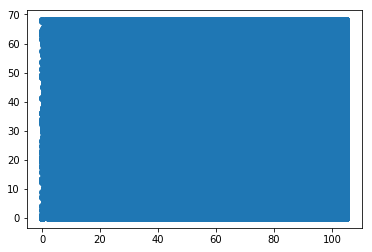

In [10]:
plt.scatter(np.array(test_game_statistics.X), np.array(test_game_statistics.Y))

In [11]:
test_game_statistics['next_x'] = test_game_statistics.X.shift(periods=-1,fill_value=None)
test_game_statistics['next_y'] = test_game_statistics.Y.shift(periods=-1,fill_value=None)
test_game_statistics['next_team'] = test_game_statistics.Team.shift(periods=-1,fill_value=None)

test_game_statistics['next_x'] = test_game_statistics.next_x.fillna(method='ffill')
test_game_statistics['next_y'] = test_game_statistics.next_y.fillna(method='ffill')
test_game_statistics['next_team'] = test_game_statistics.next_team.fillna(method='ffill')

In [12]:
test_game_statistics['team_change'] = pd.DataFrame(test_game_statistics['Team'] != test_game_statistics['next_team'],dtype='int')

In [13]:
test_game_statistics['next_x'] = test_game_statistics.apply(lambda x: x.next_x if (x.team_change==0) else 105.0-x.next_x, axis=1)
test_game_statistics['next_y'] = test_game_statistics.apply(lambda x: x.next_y if (x.team_change==0) else 68.0-x.next_y, axis=1)

In [14]:
test_game_statistics.drop(['team_change'],axis=1,inplace=True)

In [15]:
train_game_statistics = pd.read_csv("train_game_statistics.csv")

In [16]:
train_game_statistics.shape

(1571577, 28)

In [17]:
train_game_statistics['next_x'] = train_game_statistics.X.shift(periods=-1,fill_value=None)
train_game_statistics['next_y'] = train_game_statistics.Y.shift(periods=-1,fill_value=None)
train_game_statistics['next_team'] = train_game_statistics.Team.shift(periods=-1,fill_value=None)

train_game_statistics['next_x'] = train_game_statistics.next_x.fillna(method='ffill')
train_game_statistics['next_y'] = train_game_statistics.next_y.fillna(method='ffill')
train_game_statistics['next_team'] = train_game_statistics.next_team.fillna(method='ffill')

In [18]:
train_game_statistics['team_change'] = pd.DataFrame(train_game_statistics['Team'] != train_game_statistics['next_team'],dtype='int')

In [19]:
train_game_statistics['next_x'] = train_game_statistics.apply(lambda x: x.next_x if (x.team_change==0) else 105.0-x.next_x, axis=1)
train_game_statistics['next_y'] = train_game_statistics.apply(lambda x: x.next_y if (x.team_change==0) else 68.0-x.next_y, axis=1)

In [20]:
train_game_statistics.drop(['team_change'],axis=1,inplace=True)

In [21]:
Train.shape, Test.shape, train_game_statistics.shape, test_game_statistics.shape

((412, 7), (234, 6), (1571577, 28), (780234, 24))

### Feature Engineering and Modelling

In [24]:
train_game_statistics['Minutes'] = train_game_statistics['End_minutes']-train_game_statistics['Start_minutes']
test_game_statistics['Minutes'] = test_game_statistics['End_minutes']-test_game_statistics['Start_minutes']

In [25]:
xT = pd.read_csv('xT_Grid.csv',header=None)
xT = np.array(xT)
xT_rows, xT_cols = xT.shape

In [26]:
xT_rows

8

In [27]:
train_game_statistics['x1_bin'] = pd.cut(train_game_statistics['X'], bins=xT_cols, labels=False).astype('int')
train_game_statistics['y1_bin'] = pd.cut(train_game_statistics['Y'], bins=xT_rows, labels=False).astype('int')
train_game_statistics['x2_bin'] = pd.cut(train_game_statistics['next_x'], bins=xT_cols, labels=False).astype('int')
train_game_statistics['y2_bin'] = pd.cut(train_game_statistics['next_y'], bins=xT_rows, labels=False).astype('int')

train_game_statistics['start_zone_value'] = train_game_statistics[['x1_bin', 'y1_bin']].apply(lambda x: xT[x[1]][x[0]], axis=1)
train_game_statistics['end_zone_value'] = train_game_statistics[['x2_bin', 'y2_bin']].apply(lambda x: xT[x[1]][x[0]], axis=1)

train_game_statistics['xT'] = train_game_statistics['end_zone_value'] - train_game_statistics['start_zone_value']
train_game_statistics.drop(['x1_bin','y1_bin','x2_bin','y2_bin'],axis=1,inplace=True)

In [28]:
test_game_statistics['x1_bin'] = pd.cut(test_game_statistics['X'], bins=xT_cols, labels=False).astype('int')
test_game_statistics['y1_bin'] = pd.cut(test_game_statistics['Y'], bins=xT_rows, labels=False).astype('int')
test_game_statistics['x2_bin'] = pd.cut(test_game_statistics['next_x'], bins=xT_cols, labels=False).astype('int')
test_game_statistics['y2_bin'] = pd.cut(test_game_statistics['next_y'], bins=xT_rows, labels=False).astype('int')

test_game_statistics['start_zone_value'] = test_game_statistics[['x1_bin', 'y1_bin']].apply(lambda x: xT[x[1]][x[0]], axis=1)
test_game_statistics['end_zone_value'] = test_game_statistics[['x2_bin', 'y2_bin']].apply(lambda x: xT[x[1]][x[0]], axis=1)

test_game_statistics['xT'] = test_game_statistics['end_zone_value'] - test_game_statistics['start_zone_value']
test_game_statistics.drop(['x1_bin','y1_bin','x2_bin','y2_bin'],axis=1,inplace=True)

In [29]:
teams_dict = {}

for team in train_game_statistics.Team.unique():
    Train_1 = Train[Train['Home Team']==team]
    Train_2 = Train[Train['Away Team']==team]

    tdict = {}
    tdict['Home_win_proba'] = Train_1[Train_1['Score']=='Home Win'].shape[0]/Train_1.shape[0]
    tdict['Home_loss_proba'] = Train_1[Train_1['Score']=='Away win'].shape[0]/Train_1.shape[0]
    tdict['Home_draw_proba'] = Train_1[Train_1['Score']=='Draw'].shape[0]/Train_1.shape[0]

    tdict['Away_win_proba'] = Train_2[Train_2['Score']=='Away win'].shape[0]/Train_2.shape[0]
    tdict['Away_loss_proba'] = Train_2[Train_2['Score']=='Home Win'].shape[0]/Train_2.shape[0]
    tdict['Away_draw_proba'] = Train_2[Train_2['Score']=='Draw'].shape[0]/Train_2.shape[0]

    teams_dict[team] = tdict

train_teams = train_game_statistics.Team.unique()
for team in test_game_statistics.Team.unique():
    if team not in train_teams:
        tdict = {}
        tdict['Home_win_proba'] = 0.3333
        tdict['Home_loss_proba'] = 0.3333
        tdict['Home_draw_proba'] = 0.3333

        tdict['Away_win_proba'] = 0.3333
        tdict['Away_loss_proba'] = 0.3333
        tdict['Away_draw_proba'] = 0.3333

        teams_dict[team] = tdict

In [30]:
Train['Home_win_proba'] = [teams_dict[i]['Home_win_proba'] for i in Train['Home Team']]
Train['Home_loss_proba'] = [teams_dict[i]['Home_loss_proba'] for i in Train['Home Team']]
Train['Home_draw_proba'] = [teams_dict[i]['Home_draw_proba'] for i in Train['Home Team']]

Train['Away_win_proba'] = [teams_dict[i]['Away_win_proba'] for i in Train['Away Team']]
Train['Away_loss_proba'] = [teams_dict[i]['Away_loss_proba'] for i in Train['Away Team']]
Train['Away_draw_proba'] = [teams_dict[i]['Away_draw_proba'] for i in Train['Away Team']]

Test['Home_win_proba'] = [teams_dict[i]['Home_win_proba'] for i in Test['Home Team']]
Test['Home_loss_proba'] = [teams_dict[i]['Home_loss_proba'] for i in Test['Home Team']]
Test['Home_draw_proba'] = [teams_dict[i]['Home_draw_proba'] for i in Test['Home Team']]

Test['Away_win_proba'] = [teams_dict[i]['Away_win_proba'] for i in Test['Away Team']]
Test['Away_loss_proba'] = [teams_dict[i]['Away_loss_proba'] for i in Test['Away Team']]
Test['Away_draw_proba'] = [teams_dict[i]['Away_draw_proba'] for i in Test['Away Team']]

In [31]:
train_game_statistics.head(2)

,Game_ID,Player_ID,id,X,Y,Team,Action,Half,Season,Manager,Opposition_Team,Shots,SoT,Goals_scored,Goals_conceded,Accurate passes,Inaccurate passes,Passes,Start_minutes,End_minutes,next_player,next_action,next_x,next_y,event_id,next_team,next_event_id,xt_value,Minutes,start_zone_value,end_zone_value,xT
0,ID_ZZKYYPVY,Player_O7HO1NOB,1.0,52.5,34.0,Circinus,Accurate passes,1st half,2,Ryoichi,Backward,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.03,0.37,NaN,NaN,52.5,34.0,NaN,Circinus,NaN,NaN,0.34,0.014846,0.014846,0.00000
1,ID_ZZKYYPVY,Player_O7HO1NOB,2.0,52.5,34.0,Circinus,Positional attacks,1st half,2,Ryoichi,Backward,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.03,0.37,NaN,NaN,37.0,32.7,NaN,Circinus,NaN,NaN,0.34,0.014846,0.012626,-0.00222


In [33]:
train_games = Train.Game_ID.unique()
test_games = Test.Game_ID.unique()

In [34]:
train_game_dict = {}
for game in train_games:
    game_stats = train_game_statistics[train_game_statistics.Game_ID==game]
    home_team = Train[Train.Game_ID==game]['Home Team'].iloc[0]
    away_team = Train[Train.Game_ID==game]['Away Team'].iloc[0]

    home_stats = game_stats[game_stats.Team==home_team].reset_index(drop=True)
    home_stats_2 = home_stats[(home_stats['Minutes']>0.8)&(home_stats['start_zone_value']>0.02)]
    # home_stats_2 = home_stats_2[home_stats_2['xT']<=0]
    if home_stats_2.shape[0]>1:
        home_indices = home_stats_2.index.to_list()
        
        home_goal_index = [home_indices[0]]
        for i in range(1,len(home_indices)):
            if home_indices[i]-home_goal_index[-1] > 15:
                home_goal_index.append(home_indices[i])
        
        home_stats_2 = home_stats.iloc[home_goal_index]

    away_stats = game_stats[game_stats.Team==away_team].reset_index(drop=True)
    away_stats_2 = away_stats[(away_stats['Minutes']>0.8)&(away_stats['start_zone_value']>0.02)]
    # away_stats_2 = away_stats_2[away_stats_2['xT']<=0]
    if away_stats_2.shape[0]>1:
        away_indices = away_stats_2.index.to_list()
        
        away_goal_index = [away_indices[0]]
        for i in range(1,len(away_indices)):
            if away_indices[i]-away_goal_index[-1] > 15:
                away_goal_index.append(away_indices[i])
        
        away_stats_2 = away_stats.iloc[away_goal_index]

    home_stats['start_zone_value'] = home_stats['start_zone_value']*home_stats['Minutes']
    away_stats['start_zone_value'] = away_stats['start_zone_value']*away_stats['Minutes']

    game_dict = {}
    game_dict['Home_X_mean'] = np.array(home_stats.X.dropna()).mean()
    game_dict['Away_X_mean'] = np.array(away_stats.X.dropna()).mean()
    game_dict['Home_Y_mean'] = np.array(home_stats.Y.dropna()).mean()
    game_dict['Away_Y_mean'] = np.array(away_stats.Y.dropna()).mean()

    game_dict['Home_X_std'] = np.array(home_stats.X.dropna()).std()
    game_dict['Away_X_std'] = np.array(away_stats.X.dropna()).std()
    game_dict['Home_Y_std'] = np.array(home_stats.Y.dropna()).std()
    game_dict['Away_Y_std'] = np.array(away_stats.Y.dropna()).std()

    game_dict['Home_Shots_sum'] = np.array(home_stats.Shots.dropna()).sum()
    game_dict['Away_Shots_sum'] = np.array(away_stats.Shots.dropna()).sum()
    game_dict['Home_SoT_sum'] = np.array(home_stats.SoT.dropna()).sum()
    game_dict['Away_SoT_sum'] = np.array(away_stats.SoT.dropna()).sum()

    game_dict['Home_avg_mins'] = np.array(home_stats.Minutes.dropna()).mean()
    game_dict['Away_avg_mins'] = np.array(away_stats.Minutes.dropna()).mean()
    game_dict['Home_avg_xT'] = np.array(home_stats.xT.dropna()).mean()
    game_dict['Away_avg_xT'] = np.array(away_stats.xT.dropna()).mean()
    game_dict['Home_avg_start_zone'] = np.array(home_stats.start_zone_value.dropna()).mean()
    game_dict['Away_avg_start_zone'] = np.array(away_stats.start_zone_value.dropna()).mean()

    game_dict['Home_mins_std'] = np.array(home_stats.Minutes.dropna()).std()*np.sqrt(home_stats.shape[0])
    game_dict['Away_mins_std'] = np.array(away_stats.Minutes.dropna()).std()*np.sqrt(away_stats.shape[0])
    game_dict['Home_xT_std'] = np.array(home_stats.xT.dropna()).std()*np.sqrt(home_stats.shape[0])
    game_dict['Away_xT_std'] = np.array(away_stats.xT.dropna()).std()*np.sqrt(away_stats.shape[0])
    game_dict['Home_start_zone_std'] = np.array(home_stats.start_zone_value.dropna()).std()*np.sqrt(home_stats.shape[0])
    game_dict['Away_start_zone_std'] = np.array(away_stats.start_zone_value.dropna()).std()*np.sqrt(away_stats.shape[0])

    game_dict['Home_high_goal_proba'] = home_stats_2.shape[0]
    game_dict['Away_high_goal_proba'] = away_stats_2.shape[0]

    game_dict['Home_mins_range'] = np.array(home_stats.Minutes.dropna()).max()-np.array(home_stats.Minutes.dropna()).min()
    game_dict['Away_mins_range'] = np.array(away_stats.Minutes.dropna()).max()-np.array(away_stats.Minutes.dropna()).min()
    game_dict['Home_xT_range'] = np.array(home_stats.xT.dropna()).max()-np.array(home_stats.xT.dropna()).min()
    game_dict['Away_xT_range'] = np.array(away_stats.xT.dropna()).max()-np.array(away_stats.xT.dropna()).min()
    game_dict['Home_start_zone_range'] = np.array(home_stats.start_zone_value.dropna()).max()-np.array(home_stats.start_zone_value.dropna()).min()
    game_dict['Away_start_zone_range'] = np.array(away_stats.start_zone_value.dropna()).max()-np.array(away_stats.start_zone_value.dropna()).min()

    game_dict['Home_goal_zone'] = home_stats[home_stats.start_zone_value>0.02].shape[0]
    game_dict['Away_goal_zone'] = away_stats[away_stats.start_zone_value>0.02].shape[0]
    
    home_passes = np.array(home_stats.Passes.dropna()).sum()
    game_dict['Home_accurate_passes'] = 0 if home_passes==0 else np.array(home_stats['Accurate passes'].dropna()).sum()/home_passes
    game_dict['Home_inaccurate_passes'] = 0 if home_passes==0 else np.array(home_stats['Inaccurate passes'].dropna()).sum()/home_passes

    away_passes = np.array(away_stats.Passes.dropna()).sum()
    game_dict['Away_accurate_passes'] = 0 if away_passes==0 else np.array(away_stats['Accurate passes'].dropna()).sum()/away_passes
    game_dict['Away_inaccurate_passes'] = 0 if away_passes==0 else np.array(away_stats['Inaccurate passes'].dropna()).sum()/away_passes
    
    train_game_dict[game] = game_dict

In [35]:
test_game_dict = {}
for game in test_games:
    game_stats = test_game_statistics[test_game_statistics.Game_ID==game]
    home_team = Test[Test.Game_ID==game]['Home Team'].iloc[0]
    away_team = Test[Test.Game_ID==game]['Away Team'].iloc[0]
    
    home_stats = game_stats[game_stats.Team==home_team].reset_index(drop=True)
    home_stats_2 = home_stats[(home_stats['Minutes']>0.8)&(home_stats['start_zone_value']>0.02)]
    # home_stats_2 = home_stats_2[home_stats_2['xT']<=0]
    if home_stats_2.shape[0]>1:
        home_indices = home_stats_2.index.to_list()
        
        home_goal_index = [home_indices[0]]
        for i in range(1,len(home_indices)):
            if home_indices[i]-home_goal_index[-1] > 16:
                home_goal_index.append(home_indices[i])
        
        home_stats_2 = home_stats.iloc[home_goal_index]

    away_stats = game_stats[game_stats.Team==away_team].reset_index(drop=True)
    away_stats_2 = away_stats[(away_stats['Minutes']>0.8)&(away_stats['start_zone_value']>0.02)]
    # away_stats_2 = away_stats_2[away_stats_2['xT']<=0]
    if away_stats_2.shape[0]>1:
        away_indices = away_stats_2.index.to_list()
        
        away_goal_index = [away_indices[0]]
        for i in range(1,len(away_indices)):
            if away_indices[i]-away_goal_index[-1] > 16:
                away_goal_index.append(away_indices[i])
        
        away_stats_2 = away_stats.iloc[away_goal_index]

    home_stats['start_zone_value'] = home_stats['start_zone_value']*home_stats['Minutes']
    away_stats['start_zone_value'] = away_stats['start_zone_value']*away_stats['Minutes']
    
    game_dict = {}
    game_dict['Home_X_mean'] = np.array(home_stats.X.dropna()).mean()
    game_dict['Away_X_mean'] = np.array(away_stats.X.dropna()).mean()
    game_dict['Home_Y_mean'] = np.array(home_stats.Y.dropna()).mean()
    game_dict['Away_Y_mean'] = np.array(away_stats.Y.dropna()).mean()

    game_dict['Home_X_std'] = np.array(home_stats.X.dropna()).std()
    game_dict['Away_X_std'] = np.array(away_stats.X.dropna()).std()
    game_dict['Home_Y_std'] = np.array(home_stats.Y.dropna()).std()
    game_dict['Away_Y_std'] = np.array(away_stats.Y.dropna()).std()

    game_dict['Home_Shots_sum'] = np.array(home_stats.Shots.dropna()).sum()
    game_dict['Away_Shots_sum'] = np.array(away_stats.Shots.dropna()).sum()
    game_dict['Home_SoT_sum'] = np.array(home_stats.SoT.dropna()).sum()
    game_dict['Away_SoT_sum'] = np.array(away_stats.SoT.dropna()).sum()

    game_dict['Home_avg_mins'] = np.array(home_stats.Minutes.dropna()).mean()
    game_dict['Away_avg_mins'] = np.array(away_stats.Minutes.dropna()).mean()
    game_dict['Home_avg_xT'] = np.array(home_stats.xT.dropna()).mean()
    game_dict['Away_avg_xT'] = np.array(away_stats.xT.dropna()).mean()
    game_dict['Home_avg_start_zone'] = np.array(home_stats.start_zone_value.dropna()).mean()
    game_dict['Away_avg_start_zone'] = np.array(away_stats.start_zone_value.dropna()).mean()

    game_dict['Home_mins_std'] = np.array(home_stats.Minutes.dropna()).std()*np.sqrt(home_stats.shape[0])
    game_dict['Away_mins_std'] = np.array(away_stats.Minutes.dropna()).std()*np.sqrt(away_stats.shape[0])
    game_dict['Home_xT_std'] = np.array(home_stats.xT.dropna()).std()*np.sqrt(home_stats.shape[0])
    game_dict['Away_xT_std'] = np.array(away_stats.xT.dropna()).std()*np.sqrt(away_stats.shape[0])
    game_dict['Home_start_zone_std'] = np.array(home_stats.start_zone_value.dropna()).std()*np.sqrt(home_stats.shape[0])
    game_dict['Away_start_zone_std'] = np.array(away_stats.start_zone_value.dropna()).std()*np.sqrt(away_stats.shape[0])

    game_dict['Home_high_goal_proba'] = home_stats_2.shape[0]
    game_dict['Away_high_goal_proba'] = away_stats_2.shape[0]

    min_len = len(np.array(home_stats.Minutes.dropna()))
    min_len_sz = len(np.array(home_stats.start_zone_value.dropna()))

    game_dict['Home_mins_range'] = np.array(home_stats.Minutes.dropna()).max()-np.array(home_stats.Minutes.dropna()).min() if min_len>0 else 0
    game_dict['Away_mins_range'] = np.array(away_stats.Minutes.dropna()).max()-np.array(away_stats.Minutes.dropna()).min() if min_len>0 else 0
    game_dict['Home_xT_range'] = np.array(home_stats.xT.dropna()).max()-np.array(home_stats.xT.dropna()).min()
    game_dict['Away_xT_range'] = np.array(away_stats.xT.dropna()).max()-np.array(away_stats.xT.dropna()).min()
    game_dict['Home_start_zone_range'] = np.array(home_stats.start_zone_value.dropna()).max()-np.array(home_stats.start_zone_value.dropna()).min() if min_len_sz>0 else 0
    game_dict['Away_start_zone_range'] = np.array(away_stats.start_zone_value.dropna()).max()-np.array(away_stats.start_zone_value.dropna()).min() if min_len_sz>0 else 0

    game_dict['Home_goal_zone'] = home_stats[home_stats.start_zone_value>0.02].shape[0]
    game_dict['Away_goal_zone'] = away_stats[away_stats.start_zone_value>0.02].shape[0]
    
    home_passes = np.array(home_stats.Passes.dropna()).sum()
    game_dict['Home_accurate_passes'] = 0 if home_passes==0 else np.array(home_stats['Accurate passes'].dropna()).sum()/home_passes
    game_dict['Home_inaccurate_passes'] = 0 if home_passes==0 else np.array(home_stats['Inaccurate passes'].dropna()).sum()/home_passes

    away_passes = np.array(away_stats.Passes.dropna()).sum()
    game_dict['Away_accurate_passes'] = 0 if away_passes==0 else np.array(away_stats['Accurate passes'].dropna()).sum()/away_passes
    game_dict['Away_inaccurate_passes'] = 0 if away_passes==0 else np.array(away_stats['Inaccurate passes'].dropna()).sum()/away_passes
    
    test_game_dict[game] = game_dict

c:\Users\chatt\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:52: RuntimeWarning: Mean of empty slice.
c:\Users\chatt\AppData\Local\Programs\Python\Python37\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\Users\chatt\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:53: RuntimeWarning: Mean of empty slice.
c:\Users\chatt\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice.
c:\Users\chatt\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:57: RuntimeWarning: Mean of empty slice.
c:\Users\chatt\AppData\Local\Programs\Python\Python37\lib\site-packages\numpy\core\_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
c:\Users\chatt\AppData\Local\Programs\Python\Python37\lib\site-packages\numpy\core\_methods.

In [36]:
new_features = list(train_game_dict[train_games[0]].keys())

In [37]:
for feature in new_features:
    Train[feature] = [train_game_dict[i][feature] for i in Train['Game_ID']]
    Test[feature] = [test_game_dict[i][feature] for i in Test['Game_ID']]

In [38]:
Train.Date = pd.to_datetime(Train.Date)
Train['day'] = Train.Date.dt.day
Train['month'] = Train.Date.dt.month
Train['year'] = Train.Date.dt.year
Train.drop(['Date'],axis=1,inplace=True)

Test.Date = pd.to_datetime(Test.Date)
Test['day'] = Test.Date.dt.day
Test['month'] = Test.Date.dt.month
Test['year'] = Test.Date.dt.year
Test.drop(['Date'],axis=1,inplace=True)

In [39]:
Train.head(5)

,Season,Match_ID,Game_ID,Home Team,Away Team,Score,Home_win_proba,Home_loss_proba,Home_draw_proba,Away_win_proba,Away_loss_proba,Away_draw_proba,Home_X_mean,Away_X_mean,Home_Y_mean,Away_Y_mean,Home_X_std,Away_X_std,Home_Y_std,Away_Y_std,Home_Shots_sum,Away_Shots_sum,Home_SoT_sum,Away_SoT_sum,Home_avg_mins,Away_avg_mins,Home_avg_xT,Away_avg_xT,Home_avg_start_zone,Away_avg_start_zone,Home_mins_std,Away_mins_std,Home_xT_std,Away_xT_std,Home_start_zone_std,Away_start_zone_std,Home_high_goal_proba,Away_high_goal_proba,Home_mins_range,Away_mins_range,Home_xT_range,Away_xT_range,Home_start_zone_range,Away_start_zone_range,Home_goal_zone,Away_goal_zone,Home_accurate_passes,Home_inaccurate_passes,Away_accurate_passes,Away_inaccurate_passes,day,month,year
0,1,1.0,ID_KAG4KAE9,Antennae,Andromeda,Away win,0.461538,0.346154,0.192308,0.210526,0.368421,0.421053,53.727839,52.689895,34.044200,34.405077,27.018796,25.553134,19.903713,19.894320,8.0,5.0,2.0,1.0,0.334536,0.334468,0.003026,0.001946,0.008211,0.006865,1.010246,1.015682,1.027415,1.021978,0.512084,0.364629,1,2,0.50,0.50,0.487688,0.472465,0.087576,0.087576,58,52,0.779412,0.220588,0.852362,0.147638,15,2,2017
1,1,12.0,ID_T7H1XN5Z,Andromeda,Antennae,Draw,0.409091,0.227273,0.363636,0.357143,0.357143,0.285714,53.035277,53.732067,32.851739,33.959917,27.908706,27.760818,21.443460,21.984635,5.0,10.0,1.0,0.0,0.333807,0.333749,0.002785,0.002425,0.007601,0.007518,0.746137,0.746975,1.323588,1.138957,0.453895,0.463942,1,1,0.56,0.58,0.469834,0.479787,0.087576,0.087576,77,75,0.799097,0.200903,0.835498,0.164502,14,9,2016
2,1,13.0,ID_O1P9FGN4,Andromeda,Butterfly,Away win,0.409091,0.227273,0.363636,0.307692,0.230769,0.461538,48.559141,56.348191,35.550953,35.034759,23.268321,24.084399,19.144396,20.489311,3.0,6.0,0.0,2.0,0.333178,0.333048,0.001372,0.001961,0.006042,0.006872,0.590157,0.572409,0.826770,1.009072,0.337709,0.282975,0,1,0.61,0.60,0.455934,0.472465,0.085428,0.087576,49,25,0.828102,0.171898,0.719072,0.280928,12,12,2016
3,1,14.0,ID_TR5M4KQV,Andromeda,Cigar,Away win,0.409091,0.227273,0.363636,0.500000,0.250000,0.250000,47.132748,56.578500,36.709632,31.429593,25.975339,23.714139,22.173755,21.547707,5.0,11.0,2.0,3.0,0.333615,0.333357,0.002176,0.002806,0.005691,0.007501,0.534545,0.538433,0.966814,1.214455,0.228818,0.452509,0,1,0.50,0.50,0.464498,0.473441,0.085428,0.087576,11,57,0.731771,0.268229,0.791480,0.208520,25,1,2017
4,1,15.0,ID_EOIECRE2,Andromeda,Circinus,Home Win,0.409091,0.227273,0.363636,0.240000,0.520000,0.240000,50.954237,51.177291,32.658179,36.291151,25.137828,24.504412,19.310916,19.087857,13.0,5.0,2.0,0.0,0.334409,0.333576,0.002363,0.003091,0.006890,0.006745,1.169018,0.906466,1.209701,1.378523,0.454313,0.403349,2,1,0.62,0.59,0.495832,0.473053,0.214155,0.087576,52,58,0.804428,0.195572,0.798587,0.201413,24,8,2016


In [40]:
Test.head(5)

,Season,Match_ID,Game_ID,Home Team,Away Team,Home_win_proba,Home_loss_proba,Home_draw_proba,Away_win_proba,Away_loss_proba,Away_draw_proba,Home_X_mean,Away_X_mean,Home_Y_mean,Away_Y_mean,Home_X_std,Away_X_std,Home_Y_std,Away_Y_std,Home_Shots_sum,Away_Shots_sum,Home_SoT_sum,Away_SoT_sum,Home_avg_mins,Away_avg_mins,Home_avg_xT,Away_avg_xT,Home_avg_start_zone,Away_avg_start_zone,Home_mins_std,Away_mins_std,Home_xT_std,Away_xT_std,Home_start_zone_std,Away_start_zone_std,Home_high_goal_proba,Away_high_goal_proba,Home_mins_range,Away_mins_range,Home_xT_range,Away_xT_range,Home_start_zone_range,Away_start_zone_range,Home_goal_zone,Away_goal_zone,Home_accurate_passes,Home_inaccurate_passes,Away_accurate_passes,Away_inaccurate_passes,day,month,year
0,3,102,ID_8518U587,Antennae,Cosmos Redshift 7,0.461538,0.346154,0.192308,0.346154,0.346154,0.307692,47.424453,59.058587,34.668818,35.627839,28.281534,26.945699,20.153899,20.347068,11.0,15.0,1.0,5.0,0.333747,0.334247,0.002386,0.003803,0.007166,0.008472,0.887599,0.887650,1.163241,1.231497,0.517835,0.510747,1,1,0.51,0.50,0.488554,0.484673,0.214155,0.211580,51,93,0.772277,0.227723,0.834711,0.165289,12,8,2018
1,3,18,ID_H49BIKG7,Cosmos Redshift 7,Tadpole,0.576923,0.076923,0.346154,0.090909,0.181818,0.727273,51.946110,50.847557,30.926545,34.763636,29.142035,27.994084,21.299135,21.071076,6.0,8.0,2.0,2.0,0.333827,0.333791,0.002911,0.003578,0.007449,0.006909,0.735728,0.541351,1.078205,1.231927,0.443935,0.346111,1,0,0.51,0.51,0.480086,0.467041,0.214155,0.085428,69,49,0.823096,0.176904,0.769863,0.230137,9,11,2018
2,3,32,ID_PO6SP4VA,Cosmos Redshift 7,Medusa Merger,0.576923,0.076923,0.346154,0.551724,0.103448,0.344828,56.673305,53.385514,38.767380,36.366432,27.215858,25.312903,21.482290,21.435423,7.0,11.0,3.0,2.0,0.333797,0.334330,0.003630,0.002391,0.007738,0.007101,0.730067,1.017555,1.257143,1.043678,0.365317,0.432895,0,2,0.51,0.51,0.472465,0.483512,0.085428,0.211580,49,44,0.780120,0.219880,0.871579,0.128421,25,9,2018
3,3,40,ID_MZRCNBAQ,Cartwheel,Cosmos Redshift 7,0.444444,0.259259,0.296296,0.346154,0.346154,0.307692,55.637985,48.834273,32.881411,38.516101,24.531143,26.319162,20.418714,19.467130,9.0,8.0,0.0,4.0,0.333703,0.334388,0.003301,0.001884,0.007259,0.006649,0.732315,0.887594,1.230768,0.951808,0.372937,0.387738,1,1,0.50,0.51,0.473411,0.478105,0.087576,0.211580,49,38,0.854685,0.145315,0.814727,0.185273,10,2,2018
4,3,123,ID_CV9VOLIU,Cosmos Redshift 7,Needle,0.576923,0.076923,0.346154,0.333300,0.333300,0.333300,51.553621,53.701770,37.298621,30.296505,27.034148,24.404784,18.918963,18.862410,6.0,9.0,1.0,2.0,0.334678,0.334349,0.002365,0.001847,0.007533,0.006627,1.135042,1.026713,1.035169,1.038092,0.435939,0.317192,2,1,0.51,0.51,0.442131,0.479395,0.088656,0.085428,74,24,0.809406,0.190594,0.849829,0.150171,20,12,2018


#### Game statistics 

- This file shows how the game was played from start to end, the actions of the game, which player was it passed to etc.
- We will need to merge this with the train and test data provided.

In [41]:
Train["Train"] = 1
Test["Train"] = 0

train_test = pd.concat([Train, Test])

In [42]:
train_test.shape

(646, 54)

In [43]:
train_test.head(3)

,Season,Match_ID,Game_ID,Home Team,Away Team,Score,Home_win_proba,Home_loss_proba,Home_draw_proba,Away_win_proba,Away_loss_proba,Away_draw_proba,Home_X_mean,Away_X_mean,Home_Y_mean,Away_Y_mean,Home_X_std,Away_X_std,Home_Y_std,Away_Y_std,Home_Shots_sum,Away_Shots_sum,Home_SoT_sum,Away_SoT_sum,Home_avg_mins,Away_avg_mins,Home_avg_xT,Away_avg_xT,Home_avg_start_zone,Away_avg_start_zone,Home_mins_std,Away_mins_std,Home_xT_std,Away_xT_std,Home_start_zone_std,Away_start_zone_std,Home_high_goal_proba,Away_high_goal_proba,Home_mins_range,Away_mins_range,Home_xT_range,Away_xT_range,Home_start_zone_range,Away_start_zone_range,Home_goal_zone,Away_goal_zone,Home_accurate_passes,Home_inaccurate_passes,Away_accurate_passes,Away_inaccurate_passes,day,month,year,Train
0,1,1.0,ID_KAG4KAE9,Antennae,Andromeda,Away win,0.461538,0.346154,0.192308,0.210526,0.368421,0.421053,53.727839,52.689895,34.044200,34.405077,27.018796,25.553134,19.903713,19.894320,8.0,5.0,2.0,1.0,0.334536,0.334468,0.003026,0.001946,0.008211,0.006865,1.010246,1.015682,1.027415,1.021978,0.512084,0.364629,1,2,0.50,0.50,0.487688,0.472465,0.087576,0.087576,58,52,0.779412,0.220588,0.852362,0.147638,15,2,2017,1
1,1,12.0,ID_T7H1XN5Z,Andromeda,Antennae,Draw,0.409091,0.227273,0.363636,0.357143,0.357143,0.285714,53.035277,53.732067,32.851739,33.959917,27.908706,27.760818,21.443460,21.984635,5.0,10.0,1.0,0.0,0.333807,0.333749,0.002785,0.002425,0.007601,0.007518,0.746137,0.746975,1.323588,1.138957,0.453895,0.463942,1,1,0.56,0.58,0.469834,0.479787,0.087576,0.087576,77,75,0.799097,0.200903,0.835498,0.164502,14,9,2016,1
2,1,13.0,ID_O1P9FGN4,Andromeda,Butterfly,Away win,0.409091,0.227273,0.363636,0.307692,0.230769,0.461538,48.559141,56.348191,35.550953,35.034759,23.268321,24.084399,19.144396,20.489311,3.0,6.0,0.0,2.0,0.333178,0.333048,0.001372,0.001961,0.006042,0.006872,0.590157,0.572409,0.826770,1.009072,0.337709,0.282975,0,1,0.61,0.60,0.455934,0.472465,0.085428,0.087576,49,25,0.828102,0.171898,0.719072,0.280928,12,12,2016,1


In [44]:
game_statistics = pd.concat([train_game_statistics, test_game_statistics])

In [45]:
all_data = game_statistics.merge(train_test, on="Game_ID")

In [46]:
all_data.shape

(2351811, 85)

In [47]:
all_data.head()

,Game_ID,Player_ID,id,X,Y,Team,Action,Half,Season_x,Manager,Opposition_Team,Shots,SoT,Goals_scored,Goals_conceded,Accurate passes,Inaccurate passes,Passes,Start_minutes,End_minutes,next_player,next_action,next_x,next_y,event_id,next_team,next_event_id,xt_value,Minutes,start_zone_value,end_zone_value,xT,Season_y,Match_ID,Home Team,Away Team,Score,Home_win_proba,Home_loss_proba,Home_draw_proba,Away_win_proba,Away_loss_proba,Away_draw_proba,Home_X_mean,Away_X_mean,Home_Y_mean,Away_Y_mean,Home_X_std,Away_X_std,Home_Y_std,Away_Y_std,Home_Shots_sum,Away_Shots_sum,Home_SoT_sum,Away_SoT_sum,Home_avg_mins,Away_avg_mins,Home_avg_xT,Away_avg_xT,Home_avg_start_zone,Away_avg_start_zone,Home_mins_std,Away_mins_std,Home_xT_std,Away_xT_std,Home_start_zone_std,Away_start_zone_std,Home_high_goal_proba,Away_high_goal_proba,Home_mins_range,Away_mins_range,Home_xT_range,Away_xT_range,Home_start_zone_range,Away_start_zone_range,Home_goal_zone,Away_goal_zone,Home_accurate_passes,Home_inaccurate_passes,Away_accurate_passes,Away_inaccurate_passes,day,month,year,Train
0,ID_ZZKYYPVY,Player_O7HO1NOB,1.0,52.5,34.0,Circinus,Accurate passes,1st half,2,Ryoichi,Backward,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.03,0.37,NaN,NaN,52.5,34.0,NaN,Circinus,NaN,NaN,0.34,0.014846,0.014846,0.000000,2,39.0,Backward,Circinus,Home Win,0.25,0.458333,0.291667,0.24,0.52,0.24,52.927222,52.249873,33.023928,29.993028,27.899899,27.115242,20.286803,19.498788,13.0,11.0,3.0,3.0,0.334997,0.334534,0.004205,0.003021,0.008176,0.007902,1.129259,1.02406,1.350529,1.215031,0.549021,0.526525,2,1,0.51,0.51,0.502141,0.469199,0.214155,0.21158,58,96,0.765217,0.234783,0.842672,0.157328,6,12,2017,1
1,ID_ZZKYYPVY,Player_O7HO1NOB,2.0,52.5,34.0,Circinus,Positional attacks,1st half,2,Ryoichi,Backward,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.03,0.37,NaN,NaN,37.0,32.7,NaN,Circinus,NaN,NaN,0.34,0.014846,0.012626,-0.002220,2,39.0,Backward,Circinus,Home Win,0.25,0.458333,0.291667,0.24,0.52,0.24,52.927222,52.249873,33.023928,29.993028,27.899899,27.115242,20.286803,19.498788,13.0,11.0,3.0,3.0,0.334997,0.334534,0.004205,0.003021,0.008176,0.007902,1.129259,1.02406,1.350529,1.215031,0.549021,0.526525,2,1,0.51,0.51,0.502141,0.469199,0.214155,0.21158,58,96,0.765217,0.234783,0.842672,0.157328,6,12,2017,1
2,ID_ZZKYYPVY,Player_J0V7B0YE,3.0,37.0,32.7,Circinus,Positional attacks,1st half,2,Ryoichi,Backward,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.05,0.38,NaN,NaN,39.5,33.0,NaN,Circinus,NaN,NaN,0.33,0.012626,0.012626,0.000000,2,39.0,Backward,Circinus,Home Win,0.25,0.458333,0.291667,0.24,0.52,0.24,52.927222,52.249873,33.023928,29.993028,27.899899,27.115242,20.286803,19.498788,13.0,11.0,3.0,3.0,0.334997,0.334534,0.004205,0.003021,0.008176,0.007902,1.129259,1.02406,1.350529,1.215031,0.549021,0.526525,2,1,0.51,0.51,0.502141,0.469199,0.214155,0.21158,58,96,0.765217,0.234783,0.842672,0.157328,6,12,2017,1
3,ID_ZZKYYPVY,Player_J0V7B0YE,4.0,39.5,33.0,Circinus,Positional attacks,1st half,2,Ryoichi,Backward,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.07,0.40,NaN,NaN,39.5,33.0,NaN,Circinus,NaN,NaN,0.33,0.012626,0.012626,0.000000,2,39.0,Backward,Circinus,Home Win,0.25,0.458333,0.291667,0.24,0.52,0.24,52.927222,52.249873,33.023928,29.993028,27.899899,27.115242,20.286803,19.498788,13.0,11.0,3.0,3.0,0.334997,0.334534,0.004205,0.003021,0.008176,0.007902,1.129259,1.02406,1.350529,1.215031,0.549021,0.526525,2,1,0.51,0.51,0.502141,0.469199,0.214155,0.21158,58,96,0.765217,0.234783,0.842672,0.157328,6,12,2017,1
4,ID_ZZKYYPVY,Player_J0V7B0YE,5.0,39.5,33.0,Circinus,Inaccurate passes,1st half,2,Ryoichi,Backward,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.07,0.40,NaN,NaN,70.5,66.6,NaN,Backward,NaN,NaN,0.33,0.012626,0.021221,0.008595,2,39.0,Backward,Circinus,Home Win,0.25,0.458333,0.291667,0.24,0.52,0.24,52.927222,52.249873,33.023928,29.993028,27.899899,27.115242,20.286803,19.498788,13.0,11.0,3.0,3.0,0.334997,0.334534,0.004205,0.003021,0.008176,0.007902,1.129259,1.02406,1.350529,1.215031,0.549021,0.526525,2,1,0.51,0.51,0.502141,0.469199,0.214155,0.21158,58,96,0.765217,0.234783,0.842672,0.157328,6,12,2017,1

#### How to deal with column that are categorical?

- There are various ways of doing this:-

    - One hot encoding 
    - label encoding etc
    
    
- In this starter nb, I'll use label encoding, you can try other other ways

In [48]:
le = preprocessing.LabelEncoder()

all_data["Game_ID"] = le.fit_transform(all_data["Game_ID"])
game_mapping = dict(zip(le.classes_, range(len(le.classes_))))
all_data["Player_ID"] = le.fit_transform(all_data["Player_ID"])

In [49]:
Train["Game_ID"] = Train["Game_ID"].apply(lambda x: game_mapping[x])
Test["Game_ID"] = Test["Game_ID"].apply(lambda x: game_mapping[x])

- For the teams ensure they are transformed the same, you do not want a scenario where team Circinus is mapped as 1 on one column and mapped as 2 on another column, this will be inconsistent and will affect the model results

In [50]:
home_teams = Train['Home Team'].unique()
away_teams = Train['Away Team'].unique()

for team in home_teams:

    Train['home_'+team]=0
    Train.loc[Train['Home Team']==team,'home_'+team]=1

    Test['home_'+team]=0
    Test.loc[Test['Home Team']==team,'home_'+team]=1

for team in away_teams:

    Train['away_'+team]=0
    Train.loc[Train['Away Team']==team,'away_'+team]=1

    Test['away_'+team]=0
    Test.loc[Test['Away Team']==team,'away_'+team]=1

In [51]:
all_data["Team"] = le.fit_transform(all_data["Team"])

mapping = dict(zip(le.classes_, range(len(le.classes_))))

In [52]:
mapping

{'Andromeda': 0,
 'Antennae': 1,
 'Backward': 2,
 'Butterfly': 3,
 'Cartwheel': 4,
 'Cigar': 5,
 'Circinus': 6,
 'Coma Pinwheel': 7,
 'Comet': 8,
 'Cosmos Redshift 7': 9,
 'Eye of Sauron': 10,
 'Fireworks': 11,
 'Malin 1': 12,
 'Medusa Merger': 13,
 'Milky Way': 14,
 'Needle': 15,
 'Sculptor': 16,
 'Sombrero': 17,
 'Sunflower': 18,
 'Tadpole': 19,
 'Triangulum': 20,
 'Whirlpool': 21}

In [53]:
all_data["Opposition_Team"] = all_data["Opposition_Team"].apply(lambda x: mapping[x])
all_data["Home Team"] = all_data["Home Team"].apply(lambda x: mapping[x])
all_data["Away Team"] = all_data["Away Team"].apply(lambda x: mapping[x])

Train["Home Team"] = Train["Home Team"].apply(lambda x: mapping[x])
Train["Away Team"] = Train["Away Team"].apply(lambda x: mapping[x])
Test["Home Team"] = Test["Home Team"].apply(lambda x: mapping[x])
Test["Away Team"] = Test["Away Team"].apply(lambda x: mapping[x])

In [54]:
all_data["Action"] = le.fit_transform(all_data["Action"])
all_data["Half"] = le.fit_transform(all_data["Half"])
all_data["Manager"] = le.fit_transform(all_data["Manager"])

- For this nb, I'll drop most of the columns that have alot on NAN values, you can choose to fill those NAN values since the columns might be worth including in the modeling

- I'll drop also the column in train game statistics not present in the test game stats; you can use these columns for more analysis and feature engineering.

In [55]:
all_data.drop(["next_player", "next_action", "next_x", "next_y", "event_id", "next_team",
               "next_event_id", "xt_value", "Goals_conceded", "Action",], axis=1, inplace=True)

In [56]:
Train_data =all_data[all_data["Train"] == 1]
Train_data.drop("Train", axis=1, inplace=True)
Train.drop("Train", axis=1, inplace=True)
Test_data = all_data[all_data["Train"] == 0]
Test_data.drop(["Train", "Score"], axis=1, inplace=True)
Test.drop(["Train"], axis=1, inplace=True)
Test_data = Test_data.reset_index(drop=True)

c:\Users\chatt\AppData\Local\Programs\Python\Python37\lib\site-packages\pandas\core\frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [57]:
Train_data.shape, Test_data.shape

((1571577, 74), (780234, 73))

In [58]:
Train.shape, Test.shape

((412, 91), (234, 90))

In [59]:
# to avoid nans, will map score onli in the training set
Train_data["Score"] = le.fit_transform(Train_data["Score"])
score_mapping = dict(zip(le.classes_, range(len(le.classes_))))

c:\Users\chatt\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [60]:
score_mapping

{'Away win': 0, 'Draw': 1, 'Home Win': 2}

In [61]:
Train["Score"] = Train["Score"].apply(lambda x: score_mapping[x])

In [62]:
Train.head()

,Season,Match_ID,Game_ID,Home Team,Away Team,Score,Home_win_proba,Home_loss_proba,Home_draw_proba,Away_win_proba,Away_loss_proba,Away_draw_proba,Home_X_mean,Away_X_mean,Home_Y_mean,Away_Y_mean,Home_X_std,Away_X_std,Home_Y_std,Away_Y_std,Home_Shots_sum,Away_Shots_sum,Home_SoT_sum,Away_SoT_sum,Home_avg_mins,Away_avg_mins,Home_avg_xT,Away_avg_xT,Home_avg_start_zone,Away_avg_start_zone,Home_mins_std,Away_mins_std,Home_xT_std,Away_xT_std,Home_start_zone_std,Away_start_zone_std,Home_high_goal_proba,Away_high_goal_proba,Home_mins_range,Away_mins_range,Home_xT_range,Away_xT_range,Home_start_zone_range,Away_start_zone_range,Home_goal_zone,Away_goal_zone,Home_accurate_passes,Home_inaccurate_passes,Away_accurate_passes,Away_inaccurate_passes,day,month,year,home_Antennae,home_Andromeda,home_Butterfly,home_Cartwheel,home_Sculptor,home_Cigar,home_Comet,home_Cosmos Redshift 7,home_Eye of Sauron,home_Medusa Merger,home_Milky Way,home_Sunflower,home_Tadpole,home_Fireworks,home_Backward,home_Circinus,home_Coma Pinwheel,home_Sombrero,home_Triangulum,away_Andromeda,away_Antennae,away_Butterfly,away_Cigar,away_Circinus,away_Cartwheel,away_Coma Pinwheel,away_Comet,away_Cosmos Redshift 7,away_Fireworks,away_Medusa Merger,away_Milky Way,away_Backward,away_Sculptor,away_Sunflower,away_Triangulum,away_Eye of Sauron,away_Tadpole,away_Sombrero
0,1,1.0,353,1,0,0,0.461538,0.346154,0.192308,0.210526,0.368421,0.421053,53.727839,52.689895,34.044200,34.405077,27.018796,25.553134,19.903713,19.894320,8.0,5.0,2.0,1.0,0.334536,0.334468,0.003026,0.001946,0.008211,0.006865,1.010246,1.015682,1.027415,1.021978,0.512084,0.364629,1,2,0.50,0.50,0.487688,0.472465,0.087576,0.087576,58,52,0.779412,0.220588,0.852362,0.147638,15,2,2017,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,12.0,519,0,1,1,0.409091,0.227273,0.363636,0.357143,0.357143,0.285714,53.035277,53.732067,32.851739,33.959917,27.908706,27.760818,21.443460,21.984635,5.0,10.0,1.0,0.0,0.333807,0.333749,0.002785,0.002425,0.007601,0.007518,0.746137,0.746975,1.323588,1.138957,0.453895,0.463942,1,1,0.56,0.58,0.469834,0.479787,0.087576,0.087576,77,75,0.799097,0.200903,0.835498,0.164502,14,9,2016,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,13.0,415,0,3,0,0.409091,0.227273,0.363636,0.307692,0.230769,0.461538,48.559141,56.348191,35.550953,35.034759,23.268321,24.084399,19.144396,20.489311,3.0,6.0,0.0,2.0,0.333178,0.333048,0.001372,0.001961,0.006042,0.006872,0.590157,0.572409,0.826770,1.009072,0.337709,0.282975,0,1,0.61,0.60,0.455934,0.472465,0.085428,0.087576,49,25,0.828102,0.171898,0.719072,0.280928,12,12,2016,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,14.0,527,0,5,0,0.409091,0.227273,0.363636,0.500000,0.250000,0.250000,47.132748,56.578500,36.709632,31.429593,25.975339,23.714139,22.173755,21.547707,5.0,11.0,2.0,3.0,0.333615,0.333357,0.002176,0.002806,0.005691,0.007501,0.534545,0.538433,0.966814,1.214455,0.228818,0.452509,0,1,0.50,0.50,0.464498,0.473441,0.085428,0.087576,11,57,0.731771,0.268229,0.791480,0.208520,25,1,2017,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,15.0,250,0,6,2,0.409091,0.227273,0.363636,0.240000,0.520000,0.240000,50.954237,51.177291,32.658179,36.291151,25.137828,24.504412,19.310916,19.087857,13.0,5.0,2.0,0.0,0.334409,0.333576,0.002363,0.003091,0.006890,0.006745,1.169018,0.906466,1.209701,1.378523,0.454313,0.403349,2,1,0.62,0.59,0.495832,0.473053,0.214155,0.087576,52,58,0.804428,0.195572,0.798587,0.201413,24,8,2016,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Modelling

- This is a classification problem that require using classification machine learning algorithms

In [501]:
Train.columns

Index(['Season', 'Match_ID', 'Game_ID', 'Home Team', 'Away Team', 'Score',
       'Home_win_proba', 'Home_loss_proba', 'Home_draw_proba',
       'Away_win_proba', 'Away_loss_proba', 'Away_draw_proba', 'Home_X_mean',
       'Away_X_mean', 'Home_Y_mean', 'Away_Y_mean', 'Home_X_std', 'Away_X_std',
       'Home_Y_std', 'Away_Y_std', 'Home_Shots_sum', 'Away_Shots_sum',
       'Home_SoT_sum', 'Away_SoT_sum', 'Home_avg_mins', 'Away_avg_mins',
       'Home_avg_xT', 'Away_avg_xT', 'Home_avg_start_zone',
       'Away_avg_start_zone', 'Home_mins_std', 'Away_mins_std', 'Home_xT_std',
       'Away_xT_std', 'Home_start_zone_std', 'Away_start_zone_std',
       'Home_high_goal_proba', 'Away_high_goal_proba', 'Home_mins_range',
       'Away_mins_range', 'Home_xT_range', 'Away_xT_range',
       'Home_start_zone_range', 'Away_start_zone_range', 'Home_goal_zone',
       'Away_goal_zone', 'Home_accurate_passes', 'Home_inaccurate_passes',
       'Away_accurate_passes', 'Away_inaccurate_passes', 'day', 'mont

In [63]:
training = Train[(Train['year']!=2018) | (Train['month']<4)].drop(['Game_ID','Match_ID',
            'Season','year','Home_inaccurate_passes','Away_inaccurate_passes','day','month','Home_start_zone_range','Away_start_zone_range',
            'Home Team', 'Away Team','Home_mins_range','Away_mins_range','Home_goal_zone',
            'Away_goal_zone', 'Home_accurate_passes','Away_accurate_passes','Home_Shots_sum', 'Away_Shots_sum',
            'Home_SoT_sum', 'Away_SoT_sum','Away_X_mean', 'Home_Y_mean', 'Away_Y_mean', 'Home_X_std', 'Away_X_std',
            'Home_Y_std', 'Away_Y_std','Home_avg_xT', 'Away_avg_xT', 'Home_avg_start_zone',
            'Away_avg_start_zone','Home_xT_std','Away_xT_std', 'Home_start_zone_std',
            'Away_start_zone_std','Home_xT_range', 'Away_xT_range'], axis=1)
            
validation = Train[(Train['year']==2018) & (Train['month']>=4)].drop(['Game_ID','Match_ID',
            'Season','year','Home_inaccurate_passes','Away_inaccurate_passes','day','month','Home_start_zone_range','Away_start_zone_range',
            'Home Team', 'Away Team','Home_mins_range','Away_mins_range','Home_goal_zone',
            'Away_goal_zone', 'Home_accurate_passes','Away_accurate_passes','Home_Shots_sum', 'Away_Shots_sum',
            'Home_SoT_sum', 'Away_SoT_sum','Away_X_mean', 'Home_Y_mean', 'Away_Y_mean', 'Home_X_std', 'Away_X_std',
            'Home_Y_std', 'Away_Y_std','Home_avg_xT', 'Away_avg_xT', 'Home_avg_start_zone',
            'Away_avg_start_zone','Home_xT_std','Away_xT_std', 'Home_start_zone_std',
            'Away_start_zone_std','Home_xT_range', 'Away_xT_range'], axis=1)

In [451]:
# training = Train_data[(Train_data['year']!=2018) | (Train_data['month']<4)].drop(['Game_ID','Match_ID',
#             'Season_x','Season_y','year','Home_inaccurate_passes','Away_inaccurate_passes'], axis=1)
            
# validation = Train_data[(Train_data['year']==2018) & (Train_data['month']>=4)].drop(['Game_ID','Match_ID',
#             'Season_x','Season_y','year','Home_inaccurate_passes','Away_inaccurate_passes'], axis=1)

In [64]:
X_train = training.drop(["Score"], axis=1)
y_train = training["Score"]

X_val = validation.drop(["Score"], axis=1)
y_val = validation["Score"]

In [65]:
y_train.shape

(340,)

In [66]:
y_val.shape

(72,)

In [67]:
Train.head()

,Season,Match_ID,Game_ID,Home Team,Away Team,Score,Home_win_proba,Home_loss_proba,Home_draw_proba,Away_win_proba,Away_loss_proba,Away_draw_proba,Home_X_mean,Away_X_mean,Home_Y_mean,Away_Y_mean,Home_X_std,Away_X_std,Home_Y_std,Away_Y_std,Home_Shots_sum,Away_Shots_sum,Home_SoT_sum,Away_SoT_sum,Home_avg_mins,Away_avg_mins,Home_avg_xT,Away_avg_xT,Home_avg_start_zone,Away_avg_start_zone,Home_mins_std,Away_mins_std,Home_xT_std,Away_xT_std,Home_start_zone_std,Away_start_zone_std,Home_high_goal_proba,Away_high_goal_proba,Home_mins_range,Away_mins_range,Home_xT_range,Away_xT_range,Home_start_zone_range,Away_start_zone_range,Home_goal_zone,Away_goal_zone,Home_accurate_passes,Home_inaccurate_passes,Away_accurate_passes,Away_inaccurate_passes,day,month,year,home_Antennae,home_Andromeda,home_Butterfly,home_Cartwheel,home_Sculptor,home_Cigar,home_Comet,home_Cosmos Redshift 7,home_Eye of Sauron,home_Medusa Merger,home_Milky Way,home_Sunflower,home_Tadpole,home_Fireworks,home_Backward,home_Circinus,home_Coma Pinwheel,home_Sombrero,home_Triangulum,away_Andromeda,away_Antennae,away_Butterfly,away_Cigar,away_Circinus,away_Cartwheel,away_Coma Pinwheel,away_Comet,away_Cosmos Redshift 7,away_Fireworks,away_Medusa Merger,away_Milky Way,away_Backward,away_Sculptor,away_Sunflower,away_Triangulum,away_Eye of Sauron,away_Tadpole,away_Sombrero
0,1,1.0,353,1,0,0,0.461538,0.346154,0.192308,0.210526,0.368421,0.421053,53.727839,52.689895,34.044200,34.405077,27.018796,25.553134,19.903713,19.894320,8.0,5.0,2.0,1.0,0.334536,0.334468,0.003026,0.001946,0.008211,0.006865,1.010246,1.015682,1.027415,1.021978,0.512084,0.364629,1,2,0.50,0.50,0.487688,0.472465,0.087576,0.087576,58,52,0.779412,0.220588,0.852362,0.147638,15,2,2017,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,12.0,519,0,1,1,0.409091,0.227273,0.363636,0.357143,0.357143,0.285714,53.035277,53.732067,32.851739,33.959917,27.908706,27.760818,21.443460,21.984635,5.0,10.0,1.0,0.0,0.333807,0.333749,0.002785,0.002425,0.007601,0.007518,0.746137,0.746975,1.323588,1.138957,0.453895,0.463942,1,1,0.56,0.58,0.469834,0.479787,0.087576,0.087576,77,75,0.799097,0.200903,0.835498,0.164502,14,9,2016,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,13.0,415,0,3,0,0.409091,0.227273,0.363636,0.307692,0.230769,0.461538,48.559141,56.348191,35.550953,35.034759,23.268321,24.084399,19.144396,20.489311,3.0,6.0,0.0,2.0,0.333178,0.333048,0.001372,0.001961,0.006042,0.006872,0.590157,0.572409,0.826770,1.009072,0.337709,0.282975,0,1,0.61,0.60,0.455934,0.472465,0.085428,0.087576,49,25,0.828102,0.171898,0.719072,0.280928,12,12,2016,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,14.0,527,0,5,0,0.409091,0.227273,0.363636,0.500000,0.250000,0.250000,47.132748,56.578500,36.709632,31.429593,25.975339,23.714139,22.173755,21.547707,5.0,11.0,2.0,3.0,0.333615,0.333357,0.002176,0.002806,0.005691,0.007501,0.534545,0.538433,0.966814,1.214455,0.228818,0.452509,0,1,0.50,0.50,0.464498,0.473441,0.085428,0.087576,11,57,0.731771,0.268229,0.791480,0.208520,25,1,2017,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,15.0,250,0,6,2,0.409091,0.227273,0.363636,0.240000,0.520000,0.240000,50.954237,51.177291,32.658179,36.291151,25.137828,24.504412,19.310916,19.087857,13.0,5.0,2.0,0.0,0.334409,0.333576,0.002363,0.003091,0.006890,0.006745,1.169018,0.906466,1.209701,1.378523,0.454313,0.403349,2,1,0.62,0.59,0.495832,0.473053,0.214155,0.087576,52,58,0.804428,0.195572,0.798587,0.201413,24,8,2016,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [68]:
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

In [84]:
clf1 = XGBClassifier(
    n_estimators=1500,
    max_depth=12,
    learning_rate=0.1,
    min_child_weight=1,
    subsample=0.9,
    colsample_bytree=1,
    objective= 'multi:logloss',
    missing=-999,
    random_state=2019,
    tree_method='gpu_hist',
)

clf1.fit(X_train, y_train, eval_set=[(X_val,y_val)], early_stopping_rounds=150)

c:\Users\chatt\AppData\Local\Programs\Python\Python37\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:22:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:0.98250
[1]	validation_0-mlogloss:0.88686
[2]	validation_0-mlogloss:0.80571
[3]	validation_0-mlogloss:0.73034
[4]	validation_0-mlogloss:0.66655
[5]	validation_0-mlogloss:0.60925
[6]	validation_0-mlogloss:0.55858
[7]	validation_0-mlogloss:0.51350
[8]	validation_0-mlogloss:0.47287
[9]	validation_0-mlogloss:0.43785
[10]	validation_0-mlogloss:0.40611
[11]	validation_0-mlogloss:0.37822
[12]	validation_0-mlogloss:0.35307
[13]	validation_0-mlogloss:0.33049
[14]	validation_0-mlogloss:0.31061
[15]	validation_0-mlogloss:0.29242
[16]	validation_0-mlogloss:0.27617
[17]	validation_0-mlogloss:0.26265
[18]	validation_0-mlogloss:0.25021
[19]	validation_0-mlogloss:0.23930

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=0, importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=12, min_child_weight=1, missing=-999,
              monotone_constraints='()', n_estimators=1500, n_jobs=8,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=2019, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=None, subsample=1, tree_method='gpu_hist',
              validate_parameters=1, verbosity=None)

In [85]:
clf1.best_iteration

175

In [86]:
clf1.score(X_val, y_val)

0.9722222222222222

<BarContainer object of 51 artists>

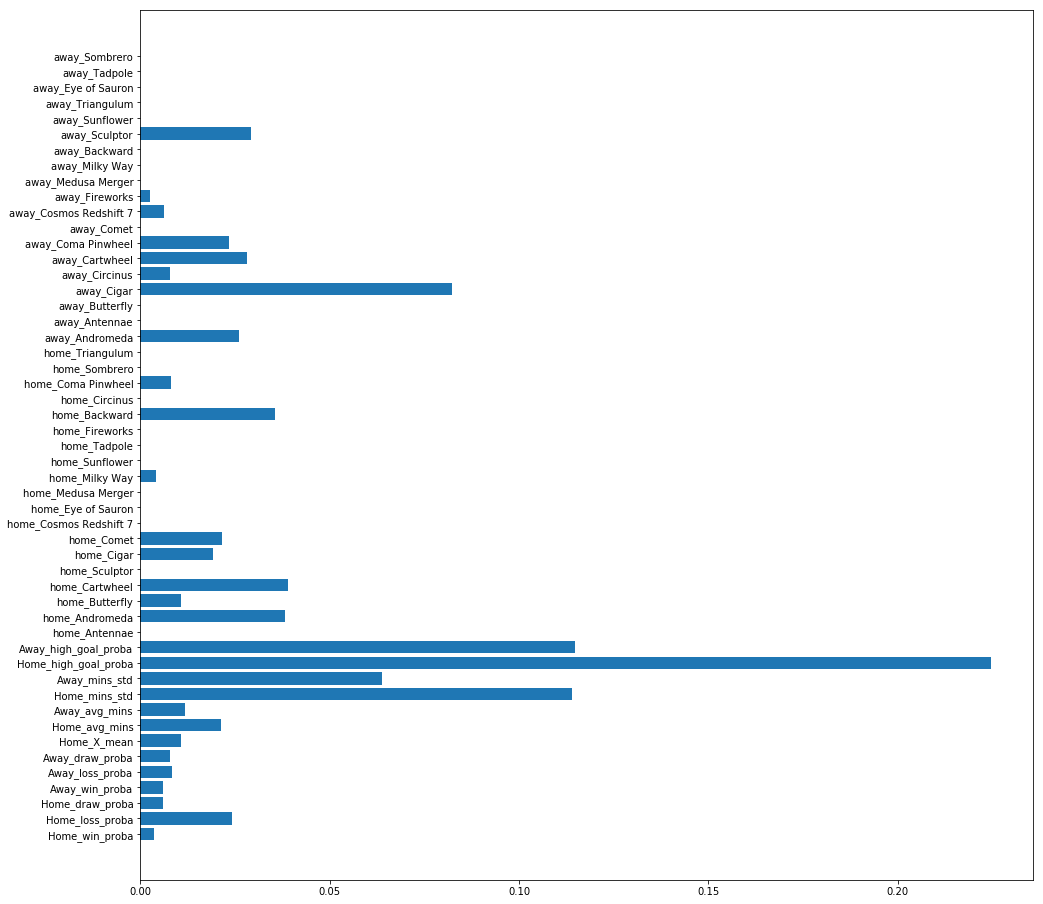

In [104]:
plt.figure(figsize=(16,16))
plt.barh(X_train.columns, clf1.feature_importances_)

In [566]:
clf1.score(X_train, y_train)

1.0

In [567]:
clf1.score(X_val, y_val)

0.9722222222222222

In [253]:
import numpy as np
np.array(clf1.predict(X_val))

array([0, 1, 2, 2, 2, 1, 1, 0, 1, 0, 2, 1, 2, 2, 0, 0, 0, 2, 2, 1, 2, 0,
       0, 1, 0, 1, 1, 2, 2, 1, 1, 2, 1, 2, 0, 2, 0, 0, 1, 2, 0, 1, 2, 2,
       1, 0, 1, 0, 2, 1, 1, 2, 1, 2, 2, 1, 2, 2, 2, 1, 0, 1, 0, 1, 0, 0,
       1, 2, 1, 2, 2, 1], dtype=int64)

In [87]:
val = pd.DataFrame(data=np.array(Train[(Train['year']==2018) & (Train['month']>=4)]['Game_ID']), columns=['Game_ID'])

yproba = clf1.predict_proba(X_val)
df2 = pd.DataFrame({'pred_0': yproba[:,0],
                    'pred_1': yproba[:,1],
                    'pred_2': yproba[:,2]},
                     index=val.index
                  )
val = pd.concat([val,df2],axis=1)

val['y'] = np.array(y_val)

In [88]:
val = val.groupby('Game_ID').agg({'pred_0': lambda x: x.sum()/x.shape[0],
                                  'pred_1': lambda x: x.sum()/x.shape[0],
                                  'pred_2': lambda x: x.sum()/x.shape[0],
                                  'y': lambda x: x.value_counts().index[0]}).reset_index()

In [89]:
val = pd.get_dummies(val, columns = ['y'], prefix=None)

In [90]:
val

,Game_ID,pred_0,pred_1,pred_2,y_0,y_1,y_2
0,6,0.014938,0.011541,0.973521,0,0,1
1,12,0.003186,0.990984,0.005830,0,1,0
2,17,0.005257,0.005130,0.989613,0,0,1
3,26,0.005584,0.986286,0.008130,0,1,0
4,27,0.004461,0.989476,0.006063,0,1,0
...,...,...,...,...,...,...,...
67,574,0.980316,0.018700,0.000984,1,0,0
68,588,0.968780,0.026585,0.004635,1,0,0
69,609,0.000740,0.004894,0.994366,0,0,1
70,621,0.015077,0.969376,0.015547,0,1,0


In [91]:
from sklearn.metrics import accuracy_score, log_loss

In [92]:
log_loss(val[['y_0','y_1','y_2']],val[['pred_0','pred_1','pred_2']])

0.13982054290837373

In [72]:
entire_data = Train.drop(['Game_ID','Match_ID',
            'Season','year','Home_inaccurate_passes','Away_inaccurate_passes','day','month','Home_start_zone_range','Away_start_zone_range',
            'Home Team', 'Away Team','Home_mins_range','Away_mins_range','Home_goal_zone',
            'Away_goal_zone', 'Home_accurate_passes','Away_accurate_passes','Home_Shots_sum', 'Away_Shots_sum',
            'Home_SoT_sum', 'Away_SoT_sum','Away_X_mean', 'Home_Y_mean', 'Away_Y_mean', 'Home_X_std', 'Away_X_std',
            'Home_Y_std', 'Away_Y_std','Home_avg_xT', 'Away_avg_xT', 'Home_avg_start_zone',
            'Away_avg_start_zone','Home_xT_std','Away_xT_std', 'Home_start_zone_std',
            'Away_start_zone_std','Home_xT_range', 'Away_xT_range'], axis=1)
X_all = entire_data.drop(["Score"], axis=1)
y_all = entire_data["Score"]

In [93]:
clf =  XGBClassifier(
    n_estimators=100,
    max_depth=12,
    learning_rate=0.1,
    min_child_weight=1,
    subsample=0.9,
    colsample_bytree=1,
    objective= 'multi:logloss',
    missing=-999,
    random_state=2019,
    tree_method='gpu_hist',
)

clf.fit(X_all, y_all)

c:\Users\chatt\AppData\Local\Programs\Python\Python37\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:23:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=0, importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=12, min_child_weight=1, missing=-999,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=2019, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=None, subsample=1, tree_method='gpu_hist',
              validate_parameters=1, verbosity=None)

### Predict on the test set

- Some of the rows in test are null, I chose to fill all NANs with 0s but you need to look at each case/column and deal with it differently

In [94]:
# Test = Test[~Test.Shots.isnull()]
Test = Test.fillna(0)

In [95]:
test_proba_predictions  = clf.predict_proba(Test.drop(['Game_ID','Match_ID',
            'Season','year','Home_inaccurate_passes','Away_inaccurate_passes','day','month','Home_start_zone_range','Away_start_zone_range',
            'Home Team', 'Away Team','Home_mins_range','Away_mins_range','Home_goal_zone',
            'Away_goal_zone', 'Home_accurate_passes','Away_accurate_passes','Home_Shots_sum', 'Away_Shots_sum',
            'Home_SoT_sum', 'Away_SoT_sum','Away_X_mean', 'Home_Y_mean', 'Away_Y_mean', 'Home_X_std', 'Away_X_std',
            'Home_Y_std', 'Away_Y_std','Home_avg_xT', 'Away_avg_xT', 'Home_avg_start_zone',
            'Away_avg_start_zone','Home_xT_std','Away_xT_std', 'Home_start_zone_std',
            'Away_start_zone_std','Home_xT_range', 'Away_xT_range'], axis=1))

In [96]:
score_mapping

{'Away win': 0, 'Draw': 1, 'Home Win': 2}

In [97]:
submit = pd.DataFrame(data=np.array(Test['Game_ID']), columns=['Game_ID'])

df2 = pd.DataFrame({'Away win': test_proba_predictions[:,0],
                    'Draw': test_proba_predictions[:,1],
                    'Home Win': test_proba_predictions[:,2]},
                     index=submit.index
                  )
submit = pd.concat([submit,df2],axis=1)

In [98]:
submit = submit.groupby('Game_ID').agg({'Away win': lambda x: x.sum()/x.shape[0],
                                  'Draw': lambda x: x.sum()/x.shape[0],
                                  'Home Win': lambda x: x.sum()/x.shape[0]}).reset_index()

In [99]:
rev_game_mapping = {value:key for key, value in game_mapping.items()}
submit["Game_ID"] = submit["Game_ID"].apply(lambda x: rev_game_mapping[x])

In [100]:
submit.shape

(234, 4)

In [101]:
submit.head(10)

,Game_ID,Away win,Draw,Home Win
0,ID_03VRW8WV,0.006610,0.989583,0.003807
1,ID_05YW7A1R,0.007415,0.925900,0.066685
2,ID_064HV3UA,0.007456,0.005694,0.986851
3,ID_06SV1XSM,0.002953,0.994478,0.002569
4,ID_08N8KYTM,0.000782,0.002520,0.996699
5,ID_0BFR12C0,0.047438,0.822406,0.130157
6,ID_0D97CTM2,0.002978,0.992209,0.004813
7,ID_0H4KVTOZ,0.001049,0.005859,0.993092
8,ID_0OW7LBXH,0.871051,0.052023,0.076926
9,ID_0UB8ADG9,0.937812,0.011610,0.050578


In [103]:
submit.to_csv("submission.csv", index=False)